In this notebook, you can find a complete set of customizable functions for:
* Loading NIFTI and DICOM files into a 3D numpy array. 
* Plotting a range of slices of the 3D image from any angle (Coronal / Sagittal / Axial):
    * With a mask overlay (segmentation mask)
    * Without masks
    


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random
import re

from tqdm import tqdm

import pydicom as dicom
import nibabel as nib


# Define hyperparameters

In [3]:
DS_RATE = 2

# Define functions to load slice images (DCM or NII format) to contruct 3D images

In [4]:
def create_3D_scans(folder, downsample_rate=1): 
    filenames = os.listdir(folder)
    filenames = [int(filename.split('.')[0]) for filename in filenames]
    filenames = sorted(filenames)
    filenames = [str(filename) + '.dcm' for filename in filenames]
        
    volume = []
    for filename in tqdm(filenames[::downsample_rate]):
        filepath = os.path.join(folder, filename)
        ds = dicom.dcmread(filepath)
        image = ds.pixel_array
        
        # find rescale params
        if ("RescaleIntercept" in ds) and ("RescaleSlope" in ds):
            intercept = float(ds.RescaleIntercept)
            slope = float(ds.RescaleSlope)
    
        # find clipping params
        center = int(ds.WindowCenter)
        width = int(ds.WindowWidth)
        low = center - width / 2
        high = center + width / 2    
        
        
        image = (image * slope) + intercept
        image = np.clip(image, low, high)

        image = (image / np.max(image) * 255).astype(np.int16)
        image = image[::downsample_rate, ::downsample_rate]
        volume.append( image )
    
    volume = np.stack(volume, axis=0)
    return volume


def create_3D_segmentations(filepath, downsample_rate=1):
    img = nib.load(filepath).get_fdata()
    img = np.transpose(img, [1, 0, 2])
    img = np.rot90(img, 1, (1,2))
    img = img[::-1,:,:]
    img = np.transpose(img, [1, 0, 2])
    img = img[::downsample_rate, ::downsample_rate, ::downsample_rate]
    return img



filepath = '/kaggle/input/rsna-2023-abdominal-trauma-detection/segmentations/21057.nii'
volume_seg = create_3D_segmentations(filepath, downsample_rate=DS_RATE)
print(f'3D segmentation file shape: {volume_seg.shape}')

filepath = '/kaggle/input/rsna-2023-abdominal-trauma-detection/train_images/10004/21057'
volume = create_3D_scans(filepath, downsample_rate=DS_RATE)
print(f'3D Image file shape: {volume.shape}')

3D segmentation file shape: (511, 256, 256)


100%|██████████| 511/511 [00:08<00:00, 63.87it/s]

3D Image file shape: (511, 256, 256)


# Define function that takes 3D images and plots slices from a specific angle (e.g. Sagittal)

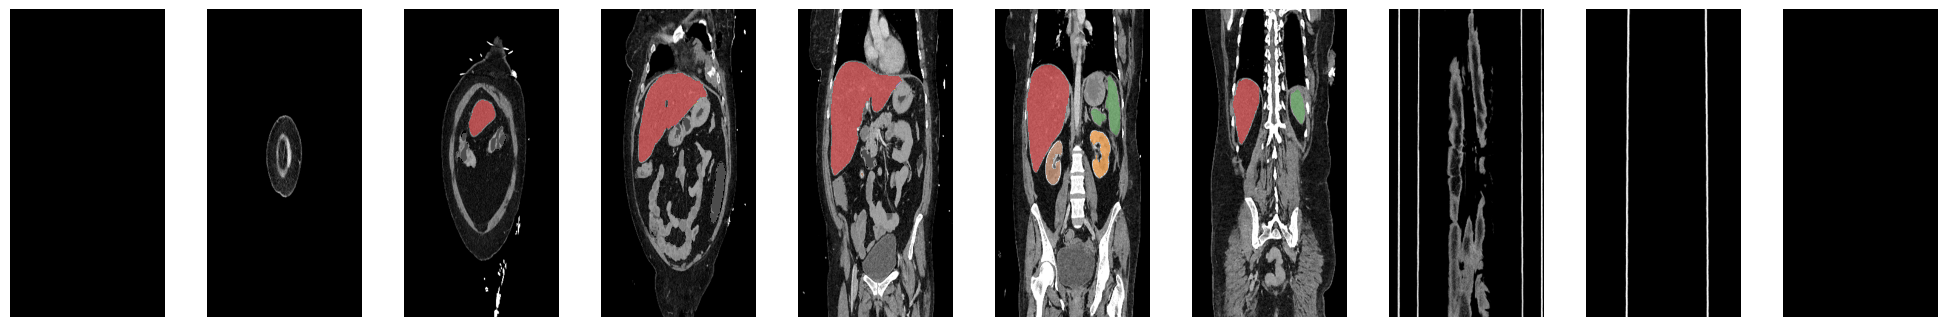

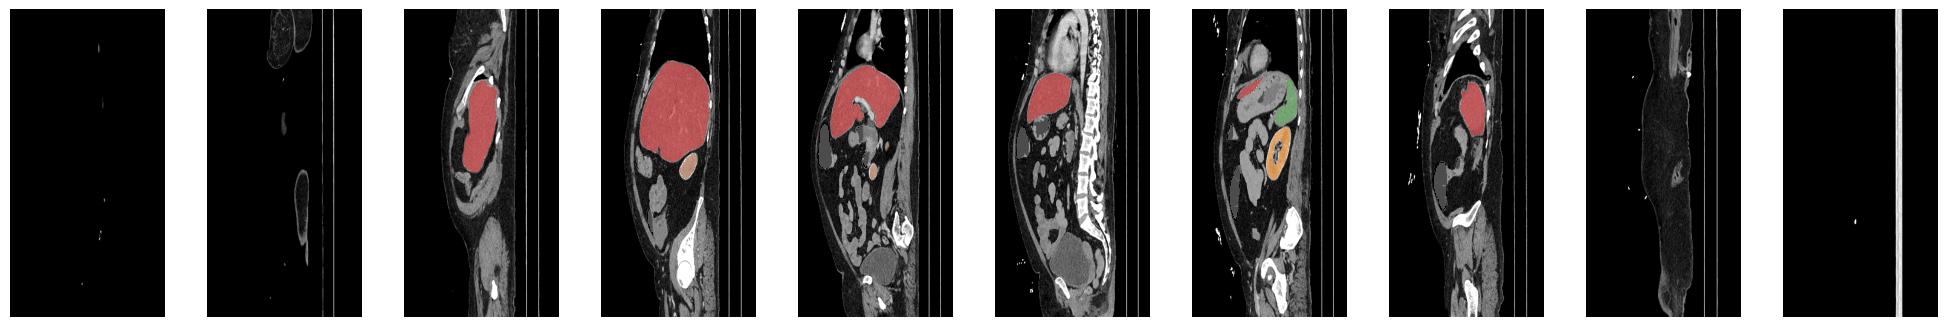

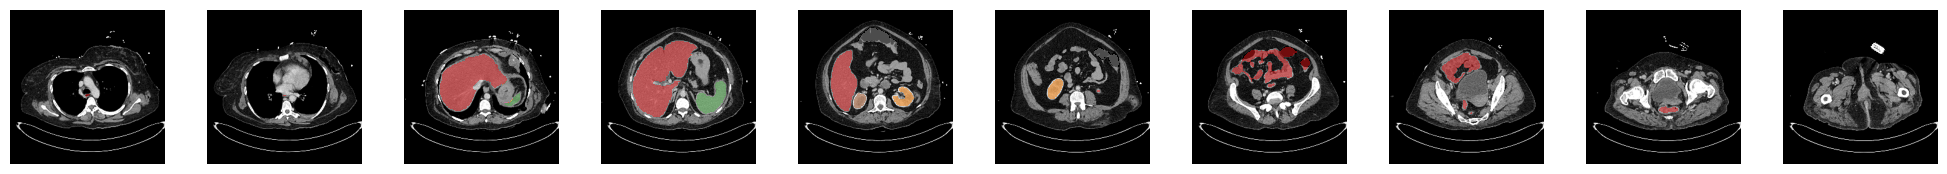

In [5]:
def plot_image_with_seg(volume, volume_seg=[], orientation='Coronal', num_subplots=20):
    # simply copy
    if len(volume_seg) == 0:
        plot_mask = 0
    else:
        plot_mask = 1
        
    if orientation == 'Coronal':
        slices = np.linspace(0, volume.shape[2]-1, num_subplots).astype(np.int16)
        volume = volume.transpose([1, 0, 2])
        if plot_mask:
            volume_seg = volume_seg.transpose([1, 0, 2])
        
    elif orientation == 'Sagittal':
        slices = np.linspace(0, volume.shape[2]-1, num_subplots).astype(np.int16)
        volume = volume.transpose([2, 0, 1])
        if plot_mask:
            volume_seg = volume_seg.transpose([2, 0, 1])

    elif orientation == 'Axial':
        slices = np.linspace(0, volume.shape[0]-1, num_subplots).astype(np.int16)
           
    rows = np.max( [np.floor(np.sqrt(num_subplots)).astype(int) - 2, 1])
    cols = np.ceil(num_subplots/rows).astype(int)
    
    fig, ax = plt.subplots(rows, cols, figsize=(cols * 2, rows * 4))
    fig.tight_layout(h_pad=0.01, w_pad=0)
    
    ax = ax.ravel()
    for this_ax in ax:
        this_ax.axis('off')

    for counter, this_slice in enumerate( slices ):
        plt.sca(ax[counter])
        
        image = volume[this_slice, :, :]
        plt.imshow(image, cmap='gray')
        
        if plot_mask:
            mask = np.where(volume_seg[this_slice, :, :], volume_seg[this_slice, :, :], np.nan)
            plt.imshow(mask, cmap='Set1', alpha=0.5)        
        
        
        
        
plot_image_with_seg(volume, volume_seg, orientation='Coronal', num_subplots=10)
plot_image_with_seg(volume, volume_seg, orientation='Sagittal', num_subplots=10)
plot_image_with_seg(volume, volume_seg, orientation='Axial', num_subplots=10)